In [ ]:
!pip install lifelines --quiet
!pip install pandas numpy matplotlib

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

In [ ]:
df = pd.read_csv("toolwindow_data.csv")

Saving toolwindow_data.csv to toolwindow_data (2).csv


In [ ]:
df = df.sort_values(by=["user_id", "timestamp"])
open_close_cycles = []

# we remove rows with null values in the user_id or timestamp fields
df = df.dropna(subset=["user_id", "timestamp"])

for user, group in df.groupby("user_id"):
    group = group.reset_index(drop=True)
    open_times, open_types, close_times = [], [], []

    for idx, row in group.iterrows():

        if row["event"] == "opened" and row["open_type"] not in ["NaN", None]:

            open_times.append(row["timestamp"])
            open_types.append(row["open_type"])

        elif row["event"] == "closed" and row["timestamp"] != None:

            close_times.append(row["timestamp"])

            # we only add a new cycle when we know it is over,
            # i.e. either we have reached the last action of the user or the next event is to open a new tool window
            is_last = idx == len(group) - 1
            is_next_open = (idx + 1 < len(group)) and (group.loc[idx + 1, "event"] == "opened")

            if (is_last or is_next_open) and open_times and close_times:
                median_open_time = np.median(open_times)
                median_close_time = np.median(close_times)
                most_common_type = max(set(open_types), key=open_types.count)

                open_close_cycles.append({
                    "open_type": most_common_type,
                    "duration_min": (median_close_time - median_open_time)/60000 # converting milliseconds to minutes
                })

                # end of the session, reseting arrays
                open_times, open_types, close_times = [], [], []

sessions_df = pd.DataFrame(open_close_cycles)

manual_sessions = sessions_df.loc[sessions_df["open_type"]=="manual", "duration_min"]
auto_sessions = sessions_df.loc[sessions_df["open_type"]=="auto", "duration_min"]


## Statistics


In [ ]:
print("----BASIC STATISTICS-----")

def summarize(group, name):
    count = group.count()
    mean = group.mean()
    median = group.median()
    min_val = group.min()
    max_val = group.max()
    std = group.std()
    var = group.var()
    sem = group.sem()
    ci_lower, ci_upper = st.t.interval(0.95, count-1, loc=mean, scale=sem)

    print(f"\n{name} statistics:")
    print(f"Count   : {count}")
    print(f"Mean    : {mean:.10f}")
    print(f"Median  : {median:.10f}")
    print(f"Min     : {min_val:.10f}")
    print(f"Max     : {max_val:.10f}")
    print(f"Std     : {std:.10f}")
    print(f"Var     : {var:.10f}")
    print(f"SEM     : {sem:.10f}")
    print(f"95% CI  : ({ci_lower:.10f}, {ci_upper:.10f})")

summarize(manual_sessions, "Manual")
summarize(auto_sessions, "Auto")


print("\n\n----SHAPIRO-WILK TEST-----")

sh_test_manual = st.shapiro(manual_sessions)
sh_test_auto = st.shapiro(auto_sessions)
print(f"Manual: statistic = {sh_test_manual.statistic:.10f}, pvalue = {sh_test_manual.pvalue}")
print(f"Auto:   statistic = {sh_test_auto.statistic:.10f}, pvalue = {sh_test_auto.pvalue}")


print("\n\n----WILCOXON-MANN-WHITNEY TEST-----")

stat, p = st.mannwhitneyu(manual_sessions, auto_sessions, alternative="two-sided")
print("p-value:", p)

----BASIC STATISTICS-----

Manual statistics:
Count   : 615
Mean    : 34.6165205962
Median  : 0.2153833333
Min     : 0.0002500000
Max     : 3702.3609666667
Std     : 244.0167473993
Var     : 59544.1730113164
SEM     : 9.8397049506
95% CI  : (15.2929624799, 53.9400787125)

Auto statistics:
Count   : 1007
Mean    : 186.8693916832
Median  : 3.6603166667
Min     : 0.0025666667
Max     : 14938.3699166667
Std     : 820.4655464604
Var     : 673163.7129285079
SEM     : 25.8550637723
95% CI  : (136.1333562911, 237.6054270754)


----SHAPIRO-WILK TEST-----
Manual: statistic = 0.1221757827, pvalue = 2.155695305931276e-46
Auto:   statistic = 0.2269427299, pvalue = 1.8356150045312375e-53


----WILCOXON-MANN-WHITNEY TEST-----
p-value: 1.2399536646141942e-66


## Visualisations

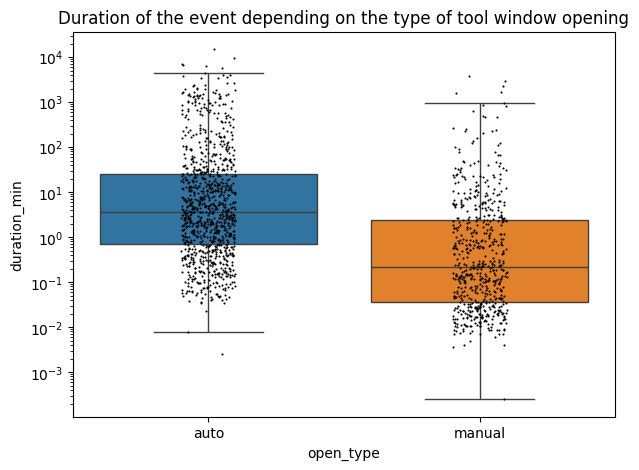

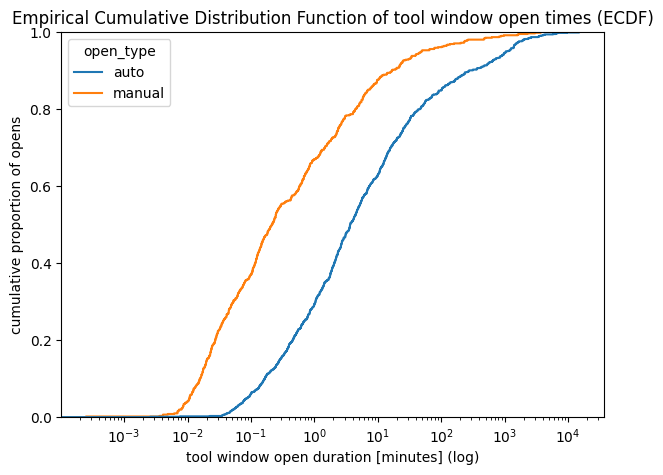

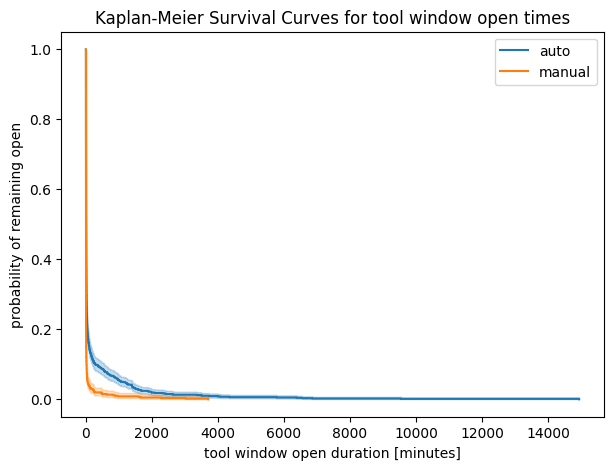

In [ ]:
# ----BOX- AND STRIPPLOT-----

plt.figure(figsize=(7,5))
plt.yscale("log")
plt.title("Duration of the event depending on the type of tool window opening")

sns.boxplot(
    x="open_type",
    y="duration_min",
    data=sessions_df,
    showfliers=False,
    palette={"manual": "#ff7f0e", "auto": "#1f77b4"},
    hue="open_type"
)

sns.stripplot(
    x="open_type",
    y="duration_min",
    data=sessions_df,
    size=1.5,
    color="black"
)

plt.show()


# ----ECDF-----

plt.figure(figsize=(7,5))
sns.ecdfplot(
    data=sessions_df,
    x="duration_min",
    hue="open_type"
)
plt.xscale("log")
plt.xlabel("tool window open duration [minutes] (log)")
plt.ylabel("cumulative proportion of opens")
plt.title("Empirical Cumulative Distribution Function of tool window open times (ECDF)")
plt.show()


# ----KAPLAN-MEIER SURVIVAL CURVES-----

kmf = KaplanMeierFitter()
plt.figure(figsize=(7,5))

for t in sessions_df["open_type"].unique():
    mask = sessions_df["open_type"] == t
    kmf.fit(sessions_df.loc[mask, "duration_min"], event_observed=[1]*mask.sum(), label=t)
    kmf.plot_survival_function()

plt.xlabel("tool window open duration [minutes]")
plt.ylabel("probability of remaining open")
plt.title("Kaplan-Meier Survival Curves for tool window open times")
plt.show()
